In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn import utils
from sklearn import model_selection
from sklearn import metrics
from sklearn import impute   

import matplotlib.pyplot as plt
sns.set_context('notebook')

# Titanic Dataset
Goal: predict whether or not a passenger survived on the Titanic based on variables such as their age, class, sex, port of origin, accompanying travelers, etc.

## Read in and prepare the data.

In [2]:
df_train_0 = pd.read_csv('data/train.csv', index_col=0)
df_train_0.columns = map(str.upper, df_train_0.columns)
display(df_train_0.head())
display(df_train_0.describe())

df_test_0 = pd.read_csv('data/test.csv', index_col=0)
df_test_0.columns = map(str.upper, df_test_0.columns)

,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,SURVIVED,PCLASS,AGE,SIBSP,PARCH,FARE
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's verify that this is a balanced classification problem.

0    0.616162
1    0.383838
Name: SURVIVED, dtype: float64


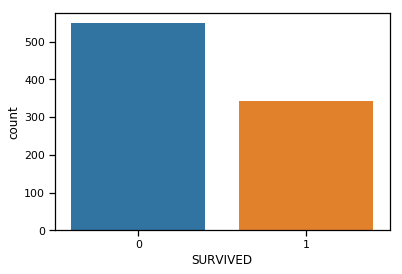

In [3]:
print(df_train_0['SURVIVED'].value_counts(normalize=True))
sns.countplot(x='SURVIVED', data=df_train_0)

Next, let's check for missing data and see how many rows are affected.

In [4]:
df_train_0.isnull().sum()

SURVIVED      0
PCLASS        0
NAME          0
SEX           0
AGE         177
SIBSP         0
PARCH         0
TICKET        0
FARE          0
CABIN       687
EMBARKED      2
dtype: int64

Here, we define a new data frame by excluding columns like name and ticket and recode sex and port of origin. 

We could use the first letter in the cabin column (the alphabet corresponding to the deck level), as passengers located on the lower decks were lower-class passengers and possibly less likely to have survived, but too many rows in this column are missing. Let's drop the cabin column since this information is probably redundantly encoded in the class column (i.e., correlated). 

Although 177 rows are missing the age information, we don't want to simply drop this column because we think that age is an important discriminating feature (based on what we know&mdash;"women and children first"&mdash;thanks to James Cameron's 1997 movie *Titanic*) that is not necessarily redundant with other columns. The simplest way to deal with the missing age column is to drop the corresponding rows, but 1. this would get rid of 177 data points, which is a lot, and 2. this may introduce undesirable bias in our results (maybe more 3rd class or younger passengers failed to report their ages). Let us instead impute, or fill in, the data using either the mean or median strategy.

In [5]:
def modify_df(df_0, missing_data='drop', impute_strategy='mean'):
    df = df_0.copy()
        
#    #only keep the alphabetical prefix for the cabin information
#    df.loc[:,'DECK'] = df.CABIN.astype(str).apply(lambda x: x[0])
    
    #transform sex, deck, and port of origin information to numerical values
    le = preprocessing.LabelEncoder()
    df['SEX'] = le.fit_transform(df['SEX'])
    print(le.classes_)
    df = pd.concat([df, pd.get_dummies(df['EMBARKED'], prefix_sep='', prefix='EMBARKED')], axis=1)    

    #drop the columns we don't need. name and ticket aren't useful features
    df = df.drop(columns=['CABIN', 'NAME', 'TICKET', 'EMBARKED'])

    #options for handling the missing data
    #remove the nan rows
    if missing_data == 'drop':
        df = df.dropna(axis=0)
    #fill in using the mean values
    elif missing_data == 'impute':
        imp = impute.SimpleImputer(missing_values=np.nan, copy=True, strategy=impute_strategy)
        imputed_df = pd.DataFrame(imp.fit_transform(df))
        imputed_df.columns = df.columns
        imputed_df.index = df.index
        df = imputed_df
        
    return df

df_train = modify_df(df_train_0, missing_data='impute')
df_test = modify_df(df_test_0, missing_data='impute')
display(df_train.head())

['female' 'male']
['female' 'male']


,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKEDC,EMBARKEDQ,EMBARKEDS
PassengerId,,,,,,,,,,
1,0.0,3.0,1.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0
2,1.0,1.0,0.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0
3,1.0,3.0,0.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0
4,1.0,1.0,0.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0
5,0.0,3.0,1.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0


Here, we see that SURVIVED = 0 is associated with a larger value of SEX, which is consistent with what we know: men were less likely to survive than women (M/F encoded to 1/0). Similarly, SURVIVED = 0 is associated with lower passenger fare.

In [6]:
print(df_train.dtypes)
print('*'*80)
print(df_train.groupby('SURVIVED').mean())

SURVIVED     float64
PCLASS       float64
SEX          float64
AGE          float64
SIBSP        float64
PARCH        float64
FARE         float64
EMBARKEDC    float64
EMBARKEDQ    float64
EMBARKEDS    float64
dtype: object
********************************************************************************
            PCLASS       SEX        AGE     SIBSP     PARCH       FARE  \
SURVIVED                                                                 
0.0       2.531876  0.852459  30.415100  0.553734  0.329690  22.117887   
1.0       1.950292  0.318713  28.549778  0.473684  0.464912  48.395408   

          EMBARKEDC  EMBARKEDQ  EMBARKEDS  
SURVIVED                                   
0.0        0.136612   0.085610   0.777778  
1.0        0.271930   0.087719   0.634503  


Let us inspect the relationship between the variables.

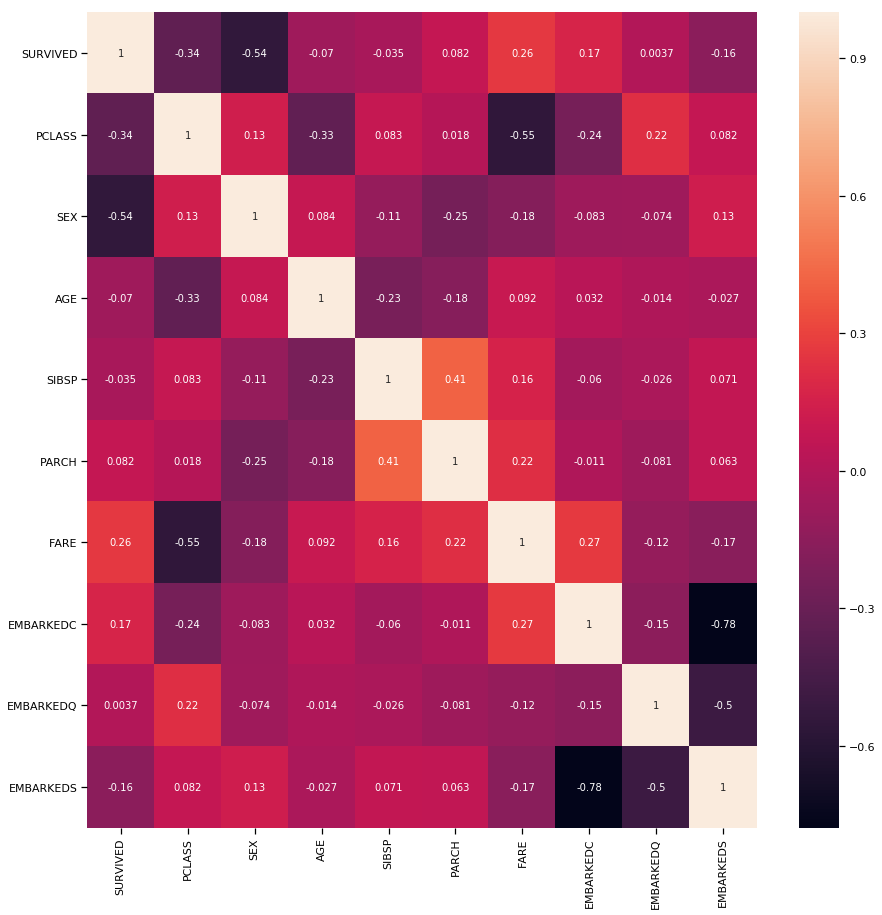

In [7]:
plt.figure(figsize=(15,15))
s = sns.heatmap(df_train.corr(), annot=True)
dummy = s.set_yticklabels(s.get_yticklabels(), rotation=0)

Before we move on to predicting the labels, first we need to standardize the data and use the same transformation for the test set as well.

In [8]:
scaler = preprocessing.StandardScaler().fit(df_train[['AGE', 'FARE']])
df_train_std = df_train.copy()
df_train_std[['AGE', 'FARE']] = scaler.transform(df_train[['AGE', 'FARE']])
df_train_std.head()

df_test_std = df_test.copy()
df_test_std[['AGE', 'FARE']] = scaler.transform(df_test[['AGE', 'FARE']])

Give the features and the labels simple names.

In [9]:
X_true_test = df_test_std
display(X_true_test.head())

y = df_train_std.SURVIVED.values
X = df_train_std.drop(columns='SURVIVED')
display(X.head())

,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKEDC,EMBARKEDQ,EMBARKEDS
PassengerId,,,,,,,,,
892,3.0,1.0,0.369449,0.0,0.0,-0.490783,0.0,1.0,0.0
893,3.0,0.0,1.331378,1.0,0.0,-0.507479,0.0,0.0,1.0
894,2.0,1.0,2.485693,0.0,0.0,-0.453367,0.0,1.0,0.0
895,3.0,1.0,-0.207709,0.0,0.0,-0.474005,0.0,0.0,1.0
896,3.0,0.0,-0.592481,1.0,1.0,-0.401017,0.0,0.0,1.0


,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKEDC,EMBARKEDQ,EMBARKEDS
PassengerId,,,,,,,,,
1,3.0,1.0,-0.592481,1.0,0.0,-0.502445,0.0,0.0,1.0
2,1.0,0.0,0.638789,1.0,0.0,0.786845,1.0,0.0,0.0
3,3.0,0.0,-0.284663,0.0,0.0,-0.488854,0.0,0.0,1.0
4,1.0,0.0,0.407926,1.0,0.0,0.420730,0.0,0.0,1.0
5,3.0,1.0,0.407926,0.0,0.0,-0.486337,0.0,0.0,1.0


## Time to Train! A Simple Approach with Logistic Regression

We will first tackle this using logistic regression to get some intuition and keep it simple by doing no hyperparameter tuning yet. We split the data to training and test sets, train the LR model on the former, then test the accuracy on the latter.

### Training the model
Logistic regression is linear regression at its core, but the hypothesis is the sigmoid, or the logistic function of the form

\begin{equation}
h_{\theta}(x) = g(\theta^T x) = \frac{1}{1+\exp(-\theta^T x)}
\end{equation}
where $x$ is the feature vector and $\theta^T$ is the transpose of the coefficients, or parameters, vector. $h_{\theta}(x)$ represents the probability of a label given $x$, and generally, if this value is greater than 0.5, then the label is assigned.

In [10]:
#split our dataset into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

#fit a LR model
lr_clf = linear_model.LogisticRegression(solver='lbfgs')
lr_clf = lr_clf.fit(X_train, y_train)

Now compute the accuracy and examine the confusion matrix using the test set that had been set aside.

Accuracy of LR: 0.776


Text(0.5, 12.5, 'Predicted Survival')

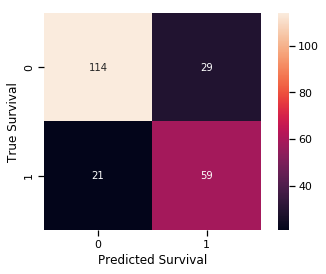

In [11]:
y_pred = lr_clf.predict(X_test)
print('Accuracy of LR: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))

cm = metrics.confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, square=True, annot=True, fmt="d")
ax.set_ylabel('True Survival')
ax.set_xlabel('Predicted Survival')

### Some insights from LR

The coefficient plot below confirms our guesses based on our prior knowledge, which we swear was based on *real facts* and not on (possibly) multiple viewings of a blockbuster film. 

Here's the takeaway: If you were male (sex = 1), lower_class (pclass = high), old (age = high), you were less likely to survive.

Text(0, 0.5, 'Coefficients')

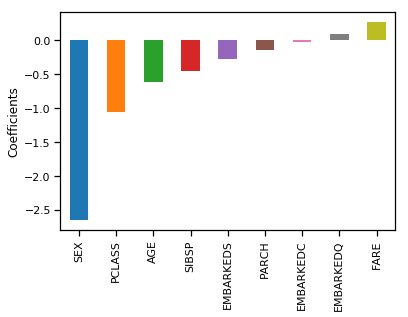

In [12]:
coef = pd.Series(lr_clf.coef_.reshape(-1,), \
                 index=X.columns).sort_values()
coef.plot(kind='bar')
plt.ylabel('Coefficients')

The table below shows why passengers who left from Chebourg ("C") were more likely to survive: more than half of the passengers who departed from Chebourg traveled in the 1st class.

In [13]:
pd.crosstab(df_train_0.EMBARKED, df_train_0.PCLASS).apply(lambda x: x/x.sum(), axis=1)

PCLASS,1,2,3
EMBARKED,,,
C,0.505952,0.101190,0.392857
Q,0.025974,0.038961,0.935065
S,0.197205,0.254658,0.548137


### Learning and Validation Curves

First we plot a learning curve, which looks pretty good. Both scores converge to a value around 0.8 and the training score is greater than the CV score by just a few percent. This suggests that adding more data here is unlikely to help much.

In [14]:
train_size, train_score, valid_score = model_selection.learning_curve(lr_clf, X, y, cv=5)

(0.7, 1.0)

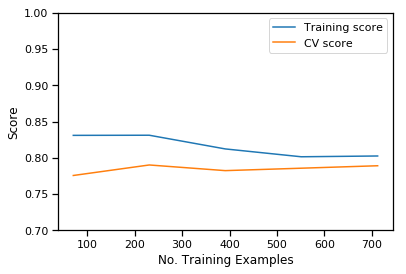

In [15]:
s = sns.lineplot(train_size, np.mean(train_score, axis=1), label='Training score')
s = sns.lineplot(train_size, np.mean(valid_score, axis=1), label='CV score')
s.set_xlabel('No. Training Examples')
s.set_ylabel('Score')
s.set_ylim(0.7, 1.0)

Here's the validation curve for the regularization parameter $C$, the inverse regularization strength such that a small $C$ corresponds to a stronger regularization (penalize large $\theta$ values). A good value seems to be roughly between 0.01 and 0.05.

In [16]:
train_score, valid_score = model_selection.validation_curve(\
    linear_model.LogisticRegression(solver='newton-cg', penalty='l2', tol=1e-4), X, y, "C", np.logspace(-3, 0.3, 20), cv=5)

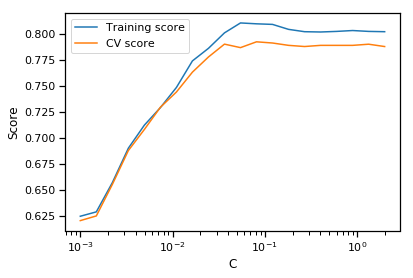

In [17]:
s = sns.lineplot(np.logspace(-3, 0.3, 20), np.mean(train_score, axis=1), label='Training score')
s = sns.lineplot(np.logspace(-3, 0.3, 20), np.mean(valid_score, axis=1), label='CV score')
s.set_xlabel('C')
s.set_ylabel('Score')
s.set_xscale('log')

# Hyperparameter Tuning & Picking the best model

Here, we'll test four algorithms: Gaussian Naive Bayes, Logistic Regression, Support Vector Machine, and Random Forests and compare their accuracies. However, all of these algorithms have hyperparameters (e.g., $C$ in LR) that need to be tuned to improve their performance. To do this, we employ a nested cross-validation. We want to avoid tuning the hyperparameters and testing the performance of the estimator on the same data set. The inner CV, where we optimize the hyperparameters, can be performed using GridSearchCV/RandomSearchCV. The outer CV is used to then evaluate the performance of the tuned model.

We reviewed LR, so let's quickly review the other three.

### 1. Naive Bayes

Try the very simple Naive Bayes method, which is based on the well-known Bayes' theorem:

\begin{equation}
P({\rm L|x}) = \frac{P({\rm {\bf x}|L})P({\rm L})}{P({\rm x})}
\end{equation}

where ${\bf x}$ represent a vector of features.

The "naive" in NB refers to the assumption that the likelihoods are the products of individual probabilities, i.e., independence among the features.

Given two possible labels $\rm L_1$ and $\rm L_2$, we can choose the best label based on the ratio 

\begin{equation}
\frac{P({\rm L_1|{\bf x}})}{P({\rm L_2|{\bf x}})} = \frac{P({\rm {\bf x}|L_1})P({\rm L_1})}{P({\rm {\bf x}|L_2})P({\rm L_2})}
\end{equation}

which also allows for probabilistic classification.

One popular approach for computing $P({\rm {\bf x}|L_1})$ is to assume that the likelihood of the features is Gaussian distributed. For simplicity, we will assume uniform priors (the $P({\rm L})$ terms). There's just one hyperparameter to optimize, var_smoothing.

### 2. SVC

Support vector classifier (or more generally, support vector machine) is based on the idea of maximizing the margin, or the separation between the different classes.

There is no built-in Linear SVC with cross validation, so let's do this explicitly. According to the documentation, the implementation is based on libsvm, and in the case of multiclass, it uses the one-vs-one scheme.

Here we will tune the hyperparameters $C$ (regularization), kernel type, and gamma (kernel coefficient).

### 3. Random Forests

Finally, we will try random forests, which is an ensemble method based on decision trees. The advantage of the ensemble method is that it reduces overfitting by averaging over multiple estimators which may be individually overfitting the data.

Ideally, first use the randomized CV search to get a rough idea for the best hyperparameter to use, then use grid search to fine-tune the values. However, grid search is very slow for RF! sklearn documentation says that the performance is slightly worse for randomized search but likely not a big issue for a held-out test set.

In [18]:
#initialize the classifiers and define the parameters (RF parameter space was roughly explored prior to this)
nbg = naive_bayes.GaussianNB()
nbg_params = {'var_smoothing': np.logspace(-15,-6,20)}

lr = linear_model.LogisticRegression(solver='lbfgs')
lr_params = {'C': [0.1,0.5,1.0,2.0,3.0,4.0,5.0]}

svc = svm.SVC()
svc_params = {'C': [0.1,0.5,1.0,2.0,3.0,4.0,5.0], \
              'kernel': ['linear','rbf'], 'gamma': [0.5,0.2,0.1,0.05,0.001,0.0001]}
            
rf = ensemble.RandomForestClassifier()
rf_params = {"n_estimators": [130,135,140,145,150], "max_features": [2,4,6,8], \
                 "max_depth": [2,4,6], "min_samples_split": [2,5,7,10,15], \
                 "min_samples_leaf": [2,5,7]}

name_list = ['NBG', 'LR', 'SVC', 'RF']
models = {'NBG': nbg, 'LR': lr, 'SVC': svc, 'RF': rf}
params = {'NBG': nbg_params, 'LR': lr_params, 'SVC': svc_params, 'RF': rf_params}

In [19]:
for i, n in enumerate(name_list):
    
    #loop through the models
    print('*'*40)
    print(n)
    print('-'*10)

    inner_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

    #increase the number of parameter combinations from default=10
    if (n == 'RF'):
        n_comb = 100
    else:
        n_comb = 1
        n_comb = [n_comb*len(params[n][k]) for k in params[n].keys()][0]
    
    #this is the inner CV to optimize the hyperparameters, performed on the "training fold" of the outer CV
    clf = model_selection.RandomizedSearchCV(models[n], params[n], \
                                       refit=True, cv=inner_cv, n_iter=n_comb, scoring='accuracy', iid=True)
    clf = clf.fit(X, y)
    
    #outer CV to compute the accuracy score. 
    #this syntax passes the "training fold" from this 5-fold CV to RandomizedSearchCV
    scores = model_selection.cross_val_score(clf, X, y, cv=outer_cv, scoring='accuracy')
    acc = np.mean(scores)
    acc_std = np.std(scores)
    
    print('Accuracy of '+n+': {:.3f}'.format(acc)+'+/-{:.3f}'.format(acc_std))

****************************************
NBG
----------
Accuracy of NBG: 0.772+/-0.016
****************************************
LR
----------
Accuracy of LR: 0.803+/-0.016
****************************************
SVC
----------
Accuracy of SVC: 0.816+/-0.018
****************************************
RF
----------
Accuracy of RF: 0.816+/-0.015


## Final thoughts & Summary

Of the four algorithms we've tested, LR, SVC, and RF performed similarly well, and only NB was noticeably inferior. Let's generate the submission file for the predictions using test.csv with the RF classifier given its marginally higher score.

In [20]:
rf = ensemble.RandomForestClassifier()
rf_params = {"n_estimators": [130,135,140,145], "max_features": [4,6,8], \
                 "max_depth": [4,6,8,10], "min_samples_split": [5,7,10,15], \
                 "min_samples_leaf": [3,4,5]}

rf_clf = model_selection.RandomizedSearchCV(rf, rf_params, \
                                            refit=True, cv=5, n_iter=200, scoring='accuracy', iid=True)
rf_clf = rf_clf.fit(X, y)
print('Optimized hyperparameters are: ', rf_clf.best_params_)

Optimized hyperparameters are:  {'n_estimators': 135, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 8}


In [21]:
y_true_pred = pd.DataFrame({'SURVIVED': rf_clf.predict(X_true_test).astype('int')})

#set the PassengerID in y_true_pred to the same one in X_true_test then concat
y_true_pred.set_index(X_true_test.index.copy(), inplace=True)
X_true_test_withpred = pd.concat([X_true_test, y_true_pred], axis=1)

#write the prediction to a csv
X_true_test_withpred[['SURVIVED']].to_csv('prediction.csv', mode='w')

The goal of this exercise was to predict the survival of Titanic passengers based on features such as age, sex, and class. Various methods were employed for comparison, from something as simple as a Gaussian Naive Bayes (worst performing) to something more complex like random forests (best performing). As suspected from the outset, some of the key features for predicting survability were sex, class, and age.

We utilized the nested CV approach to tune the hyperparameters for each algorithm, and we also used CV to compare across the four algorithms.

Possible future work includes 1. testing more algorithms and 2. exploring additional feature engineering (deal with correlated features and test higher-order and non-linear terms).